<a href="https://colab.research.google.com/github/Soulfex/Deep_Learning/blob/main/2_Retropropagaci%C3%B3n_en_red_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. Retropropagación en red densa

Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas. Esta red tiene una función de activación logística en todas sus neuronas y se entrena minimizando la función de pérdida de entropía cruzada binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún conjunto de datos.

In [18]:
#importamos librerias
import numpy as np
import math
# sistema de archivos
import os
# números aleatorios
import random

import pandas as pd

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [3]:
# Definimos la función de activación sigmoide 

def sigmoide(z):
    return 1 / (1 + np.exp(-z))

La función sigmoide tiene una derivada que está expresada en términos de la misma función, esto es, 

$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [4]:
def derivada_sigmoide(x):
    return np.multiply(sigmoide(x), (1.0 - sigmoide(x)))

usaremos la función de pérdida de entropía cruzada binaria:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [5]:
def entropia_cruzada_binaria(y, p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

Calcularemos la exactitud para medir el rendimiento del modelo aprendido por la red neuronal densa:

$$
exactitud = \frac{correctos}{total}
$$

In [6]:
def exactitud(y, y_predicha):
    return (y == y_predicha).mean() * 100

Ahora, definimos la función que propaga hacia adelante una entrada $\mathbf{x}^{i}$. Como la red está compuesta de 3 capas densas (2 ocultas y 1 de salida), tenemos 3 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}}, \mathbf{b}^{\{1\}}\}$ , $\{\mathbf{W}^{\{2\}}, \mathbf{b}^{\{2\}}\}$ y $\{\mathbf{W}^{\{3\}}, \mathbf{b}^{\{3\}}\}$ de las 2 capas ocultas y la capa de salida respectivamente. Así, podemos llevar a cabo la propagación hacia adelante en esta red de la siguiente manera:

$\mathbf{a}^{\{1\}} = \mathbf{x}^{(i)} \\
\mathbf{z}^{\{2\}} = \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}} \\
\mathbf{a}^{\{2\}} =  \sigma(\mathbf{z}^{\{2\}}) \\
\mathbf{z}^{\{3\}}  =  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}} \\ 
\mathbf{a}^{\{3\}}  =  \sigma(\mathbf{z}^{\{3\}}) \\
\mathbf{z}^{\{4\}}  =  \mathbf{W}^{\{3\}} \cdot \mathbf{a}^{\{3\}}  + \mathbf{b}^{\{3\}}\\
\mathbf{a}^{\{4\}}  =  \sigma(\mathbf{z}^{\{4\}})\\
\hat{y}^{(i)} =  \mathbf{a}^{\{4\}}
 $



			

		

In [7]:
def hacia_adelante(x, W1, b1, W2, b2, W3, b3):
  
  # Capa de entrada
  a1 = x[:, np.newaxis]
  
  # Primera capa oculta
  z2 = np.dot(W1.T, a1) + b1
  a2 = sigmoide(z2)

  # Segunda capa oculta
  z3 = np.dot(W2.T, a2) + b2
  a3 = sigmoide(z3)

  # Capa de salida 
  z4 = np.dot(W3.T, a3) + b3
  a4 = sigmoide(z4)

  # Predicción 
  y_hat = a4
  
  return z2, a2, z3, a3, z4, y_hat

Finalmente, definimos la función para entrenar nuestra red neuronal usando gradiente descendente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de retropropagación.


In [8]:
def retropropagacion(X, y, alpha = 0.01, n_epocas = 100, n_ocultas = 10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]
    
    # Inicialización de las matrices de pesos W y V
    # Primera capa oculta
    W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
    b1 = np.zeros((n_ocultas, 1))

    # Segunda capa oculta
    W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
    b2 = np.zeros((n_ocultas, 1))
    
    # Capa de salida 
    W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
    b3 = np.zeros((1, 1))
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, a3, z4, y_hat = hacia_adelante(X[j], W1, b1, W2, b2, W3, b3)

            # cálculo de gradiente para W3 por retropropagación
            dz4 = (y_hat - y[j]) * derivada_sigmoide(z4)
            dW3 = np.outer(a3, dz4)
            db3 = dz4
          
            # cálculo de gradiente para W2 por retropropagación
            dz3 = np.dot(W3, dz4) * derivada_sigmoide(z3)
            dW2 =  np.outer(a2, dz3)
            db2 = dz3
            

            # cálculo de gradiente para W1 por retropropagación
            dz2 = np.dot(W2, dz3) * derivada_sigmoide(z2)
            dW1 =  np.outer(X[j], dz2)
            db1 = dz2

            
            


            #Actualización de los parámetros
            W3 = W3 - alpha * dW3
            b3 = b3 - alpha * db3

            W2 = W2 - alpha * dW2
            b2 = b2 - alpha * db2

            W1 = W1 - alpha * dW1
            b1 = b1 - alpha * db1

            y_predicha[j] = y_hat

            


            
        # calcula la pérdida en la época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, np.round(y_predicha))
        print('Epoch {0}: Pérdida = {1} Exactitud = {2}'.format(i, 
                                                              perdidas[i], 
                                                              exactitudes[i]))

    return W1, W2, W3, perdidas, exactitudes

In [9]:
# ejemplo (XOR)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

In [10]:
np.random.seed(0)
W1, W2, W3, perdidas, exactitudes = retropropagacion(X, 
                                                 y, 
                                                 alpha = 0.25, 
                                                 n_epocas = 4000,
                                                 n_ocultas = 10)

Epoch 0: Pérdida = 2.9496606801928644 Exactitud = 50.0
Epoch 1: Pérdida = 2.9331946449495723 Exactitud = 50.0
Epoch 2: Pérdida = 2.9226317505666914 Exactitud = 50.0
Epoch 3: Pérdida = 2.9158849179025967 Exactitud = 50.0
Epoch 4: Pérdida = 2.9115761274196768 Exactitud = 50.0
Epoch 5: Pérdida = 2.9088134901463234 Exactitud = 25.0
Epoch 6: Pérdida = 2.9070269141163587 Exactitud = 25.0
Epoch 7: Pérdida = 2.905854811868908 Exactitud = 25.0
Epoch 8: Pérdida = 2.905068931795105 Exactitud = 25.0
Epoch 9: Pérdida = 2.9045256051374384 Exactitud = 25.0
Epoch 10: Pérdida = 2.9041345563799448 Exactitud = 25.0
Epoch 11: Pérdida = 2.9038391152069147 Exactitud = 25.0
Epoch 12: Pérdida = 2.9036037252843503 Exactitud = 25.0
Epoch 13: Pérdida = 2.9034060829932953 Exactitud = 25.0
Epoch 14: Pérdida = 2.9032321987796346 Exactitud = 25.0
Epoch 15: Pérdida = 2.9030732976788864 Exactitud = 25.0
Epoch 16: Pérdida = 2.9029238751191606 Exactitud = 25.0
Epoch 17: Pérdida = 2.902780477671798 Exactitud = 25.0
Epoch

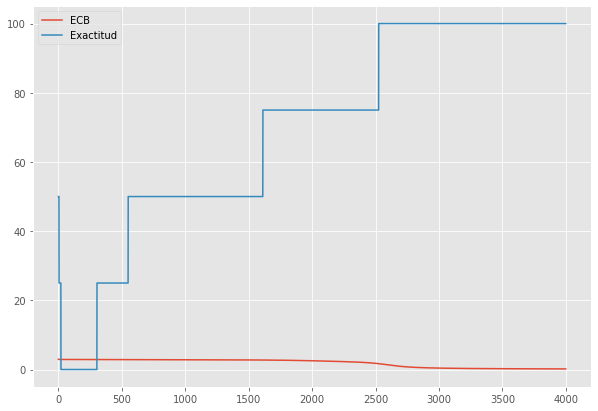

In [11]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")


plt.figure(figsize= (10, 7))
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

## Entrena y evalúa la red en algún conjunto de datos.



In [15]:
# Para probar la red, usaremos el conjunto de datos de las calificaciones
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv'
data_dir = '../data'
filepath = os.path.join(data_dir, 'califs.csv')

In [16]:
! mkdir {data_dir}
! wget -nc {URL} -O {filepath}

--2022-09-27 00:36:58--  https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666 [text/plain]
Saving to: ‘../data/califs.csv’

../data/califs.csv  100%[===================>]     666  --.-KB/s    in 0s      

2022-09-27 00:36:58 (30.0 MB/s) - ‘../data/califs.csv’ saved [666/666]



In [25]:
df = pd.read_csv(filepath)
df.head(5)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


In [26]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   prev    50 non-null     float64
 1   horas   50 non-null     float64
 2   calif   50 non-null     float64
dtypes: float64(3)
memory usage: 1.3 KB


None

In [ ]:
# Vamos a marcar a los que tienen calificación aprobatoría con un 1 y a los que no con un 0

In [27]:
df["new_calif"] =( df["calif"] >= 6) * 1

In [52]:
df.head(10)

,prev,horas,calif,new_calif
0,5.6,8.2,5.1,0
1,6.7,9.3,5.9,0
2,5.1,10.0,5.4,0
3,5.7,10.4,6.5,1
4,7.1,10.4,6.7,1
5,6.4,10.4,6.0,1
6,6.1,10.4,6.8,1
7,6.8,10.5,6.2,1
8,6.3,10.7,7.2,1
9,6.2,10.9,7.2,1


In [58]:
# Probemos la red
np.random.seed(0)
X = df.iloc[:10,:-2].values
y = df.iloc[:10,[-1]].values
W1, W2, W3, perdidas, exactitudes = retropropagacion(X, 
                                                 y, 
                                                 alpha = 0.1, 
                                                 n_epocas = 5000,
                                                 n_ocultas = 10)

Epoch 0: Pérdida = 6.468245754338909 Exactitud = 70.0
Epoch 1: Pérdida = 6.350668800313782 Exactitud = 70.0
Epoch 2: Pérdida = 6.280420100875295 Exactitud = 70.0
Epoch 3: Pérdida = 6.23827277866862 Exactitud = 70.0
Epoch 4: Pérdida = 6.212988129980008 Exactitud = 70.0
Epoch 5: Pérdida = 6.197936526831505 Exactitud = 70.0
Epoch 6: Pérdida = 6.189149756287433 Exactitud = 70.0
Epoch 7: Pérdida = 6.184216217423991 Exactitud = 70.0
Epoch 8: Pérdida = 6.181650382156226 Exactitud = 70.0
Epoch 9: Pérdida = 6.180527388707383 Exactitud = 70.0
Epoch 10: Pérdida = 6.180267336113855 Exactitud = 70.0
Epoch 11: Pérdida = 6.180505538431998 Exactitud = 70.0
Epoch 12: Pérdida = 6.181013095530411 Exactitud = 70.0
Epoch 13: Pérdida = 6.181647493135509 Exactitud = 70.0
Epoch 14: Pérdida = 6.182321457643219 Exactitud = 70.0
Epoch 15: Pérdida = 6.182983096927446 Exactitud = 70.0
Epoch 16: Pérdida = 6.183603124637025 Exactitud = 70.0
Epoch 17: Pérdida = 6.184166589063132 Exactitud = 70.0
Epoch 18: Pérdida = 6

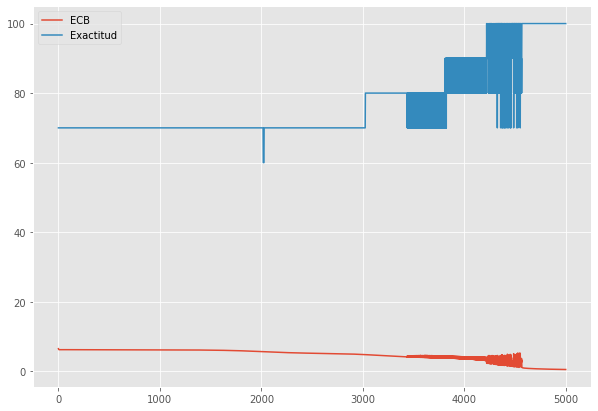

In [61]:
style.use("ggplot")


plt.figure(figsize= (10, 7))
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()